In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from newdust import *
from newdust import graindist
from newdust import extinction

In [3]:
EVALS = np.logspace(-1,1,30) # keV
LAMVALS = np.linspace(1000.,8000., 100) # angs

### How to construct a SingleGrainPop object

In [5]:
sgpop = SingleGrainPop(graindist.make_GrainDist('Powerlaw','Silicate'), 'Mie')
sgpop.calculate_ext(LAMVALS, unit='angs')

[]

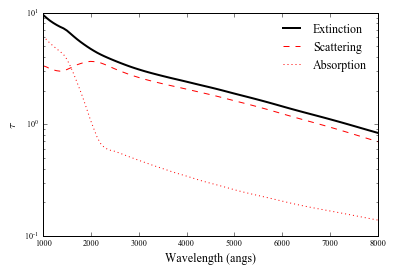

In [6]:
ax = plt.subplot(111)
sgpop.plot_ext(ax, 'all', loc='upper right', frameon=False)
plt.semilogy()

[]

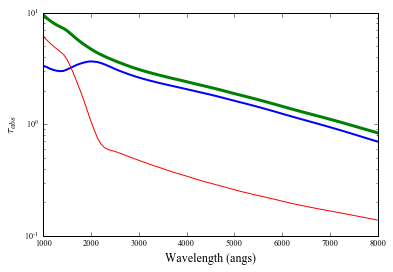

In [7]:
ax = plt.subplot(111)
sgpop.plot_ext(ax, 'ext', color='g', lw=3)
sgpop.plot_ext(ax, 'sca', color='b', lw=2)
sgpop.plot_ext(ax, 'abs', color='r', lw=1)
plt.semilogy()

## SingleGrainPop objects can be combined into a larger GrainPop

In [9]:
silpop = SingleGrainPop(graindist.make_GrainDist('Powerlaw','Silicate'), 'Mie')
grapop = SingleGrainPop(graindist.make_GrainDist('Powerlaw','Graphite'), 'Mie')

myPop  = GrainPop([silpop, grapop], keys=['sil','gra'])

In [10]:
myPop.calculate_ext(LAMVALS, unit='angs')

[]

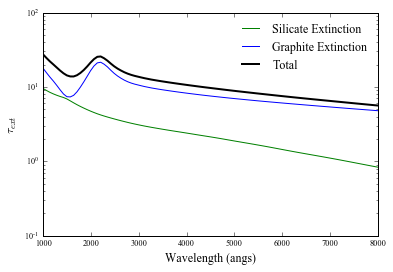

In [11]:
ax = plt.subplot(111)
myPop['sil'].plot_ext(ax, 'ext', color='g', label='Silicate Extinction')
myPop['gra'].plot_ext(ax, 'ext', color='b', label='Graphite Extinction')
myPop.plot_ext(ax, 'ext', color='k', lw=2, label='Total')
ax.legend(loc='upper right', frameon=False)
plt.semilogy()

In [12]:
myPop.info()

General information for Custom_GrainPopDict dust grain population
---
Grain Population: sil
Size distribution: Powerlaw
Extinction calculated with: Mie
Grain composition: Silicate
rho = 3.80 g cm^-3, M_d = 1.00e-04 g cm^-2
---
Grain Population: gra
Size distribution: Powerlaw
Extinction calculated with: Mie
Grain composition: Graphite
rho = 2.20 g cm^-3, M_d = 1.00e-04 g cm^-2


## Shortcut (helper) functions

In [13]:
NH = 1.e22 # cm^-2
MD = NH * 0.009 * constants.m_p

### make_MRN

In [14]:
mrn = make_MRN(md=MD)
mrn.calculate_ext(LAMVALS, unit='angs')

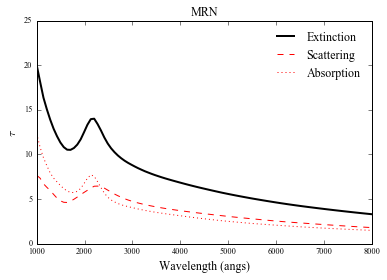

In [15]:
ax = plt.subplot(111)
mrn.plot_ext(ax, 'all', frameon=False)

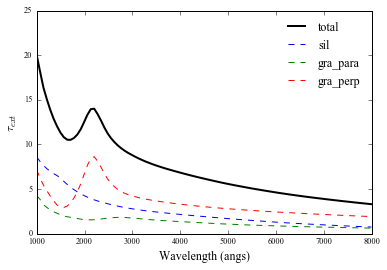

In [16]:
ax = plt.subplot(111)
mrn.plot_ext(ax, 'ext', color='k', lw=2, label='total')
for k in mrn.keys:
    mrn[k].plot_ext(ax, 'ext', ls='--', label=k)
ax.legend(loc='upper right', frameon=False)

In [17]:
mrn.info()

General information for MRN dust grain population
---
Grain Population: sil
Size distribution: Powerlaw
Extinction calculated with: Mie
Grain composition: Silicate
rho = 3.80 g cm^-3, M_d = 9.03e-05 g cm^-2
---
Grain Population: gra_para
Size distribution: Powerlaw
Extinction calculated with: Mie
Grain composition: Graphite
rho = 2.20 g cm^-3, M_d = 2.01e-05 g cm^-2
---
Grain Population: gra_perp
Size distribution: Powerlaw
Extinction calculated with: Mie
Grain composition: Graphite
rho = 2.20 g cm^-3, M_d = 4.02e-05 g cm^-2


### make_MRN_drude

In [18]:
mrn_rgd = make_MRN_drude(md=MD)
mrn_rgd.calculate_ext(EVALS, unit='kev')

[]

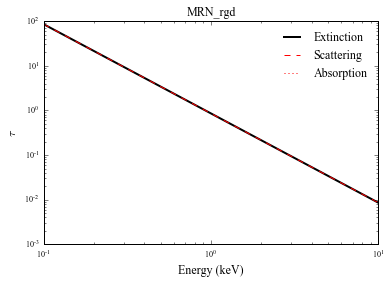

In [19]:
ax = plt.subplot(111)
mrn_rgd.plot_ext(ax, 'all')
plt.loglog()

In [20]:
mrn_rgd.info()

General information for MRN_rgd dust grain population
---
Grain Population: RGD
Size distribution: Powerlaw
Extinction calculated with: RGscat
Grain composition: Drude
rho = 3.00 g cm^-3, M_d = 1.51e-04 g cm^-2
